In [1]:
#@title MIT License
#
# Copyright (c) 2019 Andreas Eberlein
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Predict hiking times based on statistics from GPX files

We attempt to predict the walking times (or more precisely the moving times) for hikes based on statistics extracted from GPX files. Using personal GPX records as input, the outputs are personalized as well.

The code is based on the `basic_regression.ipynb` notebook from [Tensorflow tutorials](https://github.com/tensorflow/docs/blob/r1.13/site/en/tutorials/keras/basic_regression.ipynb).

We use the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


### Load data
Load the dataset that was prepared by running `prepareData.py`.

In [3]:
dataset_path = 'hiking_data.csv'
dataset_path

'hiking_data.csv'

Convert data to a pandas dataframe:

In [4]:
import gpxStats

column_names = gpxStats.GpxStats.getHeader()
raw_dataset = pd.read_csv(dataset_path, header=0,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

raw_dataset.pop('Name')

dataset = raw_dataset.copy()
dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,MaxSpeed,TotalUphill,TotalDownhill
27,5243.076831,5281.999032,4833.0,4547.0,286.0,1.803100,245.8,217.8
28,19041.915231,19243.293370,25050.0,20648.0,4402.0,1.617043,1126.1,420.1
29,5558.221065,5623.842801,5956.0,5652.0,304.0,2.060267,145.8,333.8
30,9581.878271,9937.377262,17899.0,12789.0,5110.0,2.185877,757.0,784.0
31,10254.193843,10565.320829,15016.0,11498.0,3518.0,1.695120,1070.0,480.0


### Clean the data

Inspect dataset and see if there are unknown values:

In [5]:
dataset.isna().sum()

Length2d         0
Length3d         0
Duration         0
MovingTime       0
StoppedTime      0
MaxSpeed         0
TotalUphill      0
TotalDownhill    0
dtype: int64

The data looks fine, so we do not have to clean it.

In [6]:
# dataset = dataset.dropna()

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the data set.

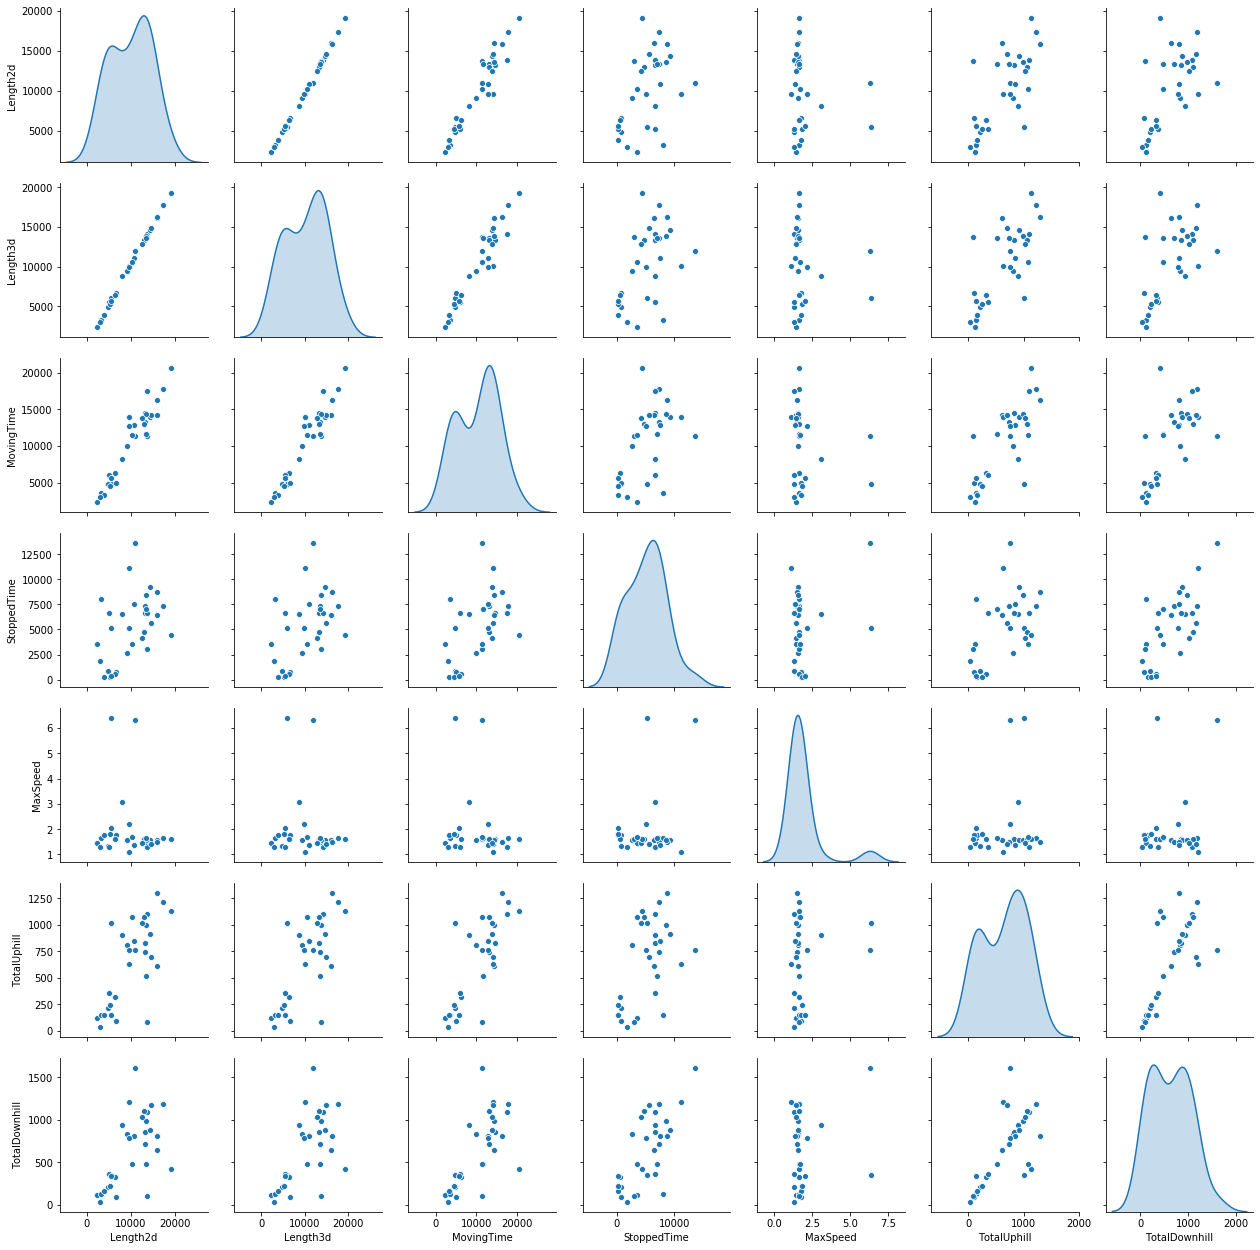

In [7]:
sns.pairplot(dataset[["Length2d", "Length3d", "MovingTime", "StoppedTime", "MaxSpeed", "TotalUphill", "TotalDownhill"]], diag_kind="kde")

Also look at the overall statistics:

In [8]:
dataset_stats = dataset.describe()
dataset_stats.pop("MovingTime")
dataset_stats = dataset_stats.transpose()
dataset_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,32.0,10115.801685,4657.491801,2298.224548,5524.403329,10526.186907,13610.007893,19041.915231
Length3d,32.0,10375.926335,4715.438571,2335.560357,5935.985379,10827.067029,13773.806865,19243.293370
Duration,32.0,15782.062500,7370.238408,3572.000000,9199.500000,17852.000000,21544.750000,25188.000000
StoppedTime,32.0,5260.781250,3335.640053,239.000000,2930.500000,5405.500000,7370.750000,13633.000000
MaxSpeed,32.0,1.916528,1.211984,1.095778,1.447927,1.602174,1.709983,6.392106
TotalUphill,32.0,650.246612,393.111939,34.819992,238.164987,750.119989,998.534601,1299.260278
TotalDownhill,32.0,637.915455,417.520993,32.019989,296.925073,675.899921,945.444873,1612.700000


The `"Name"` column does not contain information about the walking time, so we dropped it. Visual inspection suggests that there is no useful correlation between `"MovingTime"` and `"Duration"` or `"StoppedTime"`, as the latter two depend on how often the GPX device is paused when waiting or taking a break during a hike. Thus, we drop these two columns as well. `"MaxSpeed"` does not contain useful information for our purpose, and seems to be uncorrelated with the `"MovingTime."`

In [9]:
dataset.pop('Duration')
dataset.pop('StoppedTime')
dataset.pop('MaxSpeed')
dataset.tail()

,Length2d,Length3d,MovingTime,TotalUphill,TotalDownhill
27,5243.076831,5281.999032,4547.0,245.8,217.8
28,19041.915231,19243.293370,20648.0,1126.1,420.1
29,5558.221065,5623.842801,5652.0,145.8,333.8
30,9581.878271,9937.377262,12789.0,757.0,784.0
31,10254.193843,10565.320829,11498.0,1070.0,480.0


### Split the data into train and test datasets

Now we split the dataset into a training set and a test set. We will use the test set in the final evaluation of our model.

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Obtain statistics about the training set for normalization:

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MovingTime")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,26.0,10130.492768,4997.984262,2298.224548,5456.767858,10526.186907,13778.234413,19041.915231
Length3d,26.0,10341.524344,5056.280002,2335.560357,5727.890327,10827.067029,14085.697137,19243.293370
TotalUphill,26.0,632.903546,417.616117,34.819992,165.325055,726.579816,1006.444867,1299.260278
TotalDownhill,26.0,562.565198,373.988732,32.019989,238.820004,476.370143,848.155058,1189.799989


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

In [12]:
train_labels = train_dataset.pop('MovingTime')
test_labels = test_dataset.pop('MovingTime')

### Normalize the data

The statistics about `train_stats` in the above block shows a wide variation of ranges for all features. Although a model *might* converge without feature normalization, the latter usually improves convergence properties.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset and the pretraining data set. We need to do that to project the test dataset into the same distribution as the one the model has been trained on.

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

with open('train_stats.csv', 'w') as csvfile:
    train_stats.to_csv(csvfile, sep=' ')


`normed_train_data` is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model. This includes the test dataset as well as input during inference. Thus we need to save the normalization numbers together with the model.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, for convencience.

In [14]:
learning_rate = 0.001

def build_model(learn_rate=learning_rate):
    model = keras.Sequential([
        layers.Dense(16, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(lr=learn_rate)

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model(learning_rate)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


How did we specify the architecture of the model?

The architecture is chosen such that we can reproduce esimates for walking times from a standard formula that is implemented in the function `compute_standard_walking_time` in `utils.py`. 

In principle, we would not need pretraining. However, as our set of GPX tracks from hiking is quite small, pretraining is helpful for designing the model and for making training more smooth.

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `4` examples from the training data and call `model.predict` on it.

In [16]:
example_batch = normed_train_data[:4]
example_result = model.predict(example_batch)
example_result

array([[-0.22526133],
       [-0.1203062 ],
       [-0.1953086 ],
       [-0.12087862]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Pretrain the model

The number of personal gpx tracks is quite limited so far (just around 30 tracks are available -- I should go hiking more often...). In order to obtain a better model, we try to pretrain our model with data from a standard formula for estimating hiking times. Afterwards, we fine tune the model with own GPX tracks for personalization.

#### Generation of data set for pretraining

In [17]:
import utils

length2d = []
uphill = []
downhill = []
moving_time = []
for l2d in range(0, 20000, 800):            # Length up to 800 * 25 m = 20 km
    for up in range(0, 2500, 100):          # Uphill up to 25 * 100 m = 2500 m
        for down in range(0, 2500, 100):    # Downhill up to 25 * 100 m = 2500 m
            length2d.append(l2d)
            uphill.append(up)
            downhill.append(down)
            moving_time.append(utils.compute_standard_walking_time(l2d, up, down))

col_names = gpxStats.GpxStats.getHeader()
raw_pretrain_data = {col_names[1]: length2d,    # Note: We use length2d as input for the 2d and 3d length, as we
                     col_names[2]: length2d,    #       do not have a good model for the relation between the two...
                     col_names[4]: moving_time,
                     col_names[7]: uphill,
                     col_names[8]: downhill}
    
pretrain_dataset = pd.DataFrame(data=raw_pretrain_data)

# Separating 'MovingTime' to pretrain_labels
pretrain_labels = pretrain_dataset.pop('MovingTime')

# Normalize data for pretraining:
normed_pretrain_data = norm(pretrain_dataset)

pretrain_dataset.tail()

,Length2d,Length3d,TotalUphill,TotalDownhill
15620,19200,19200,2400,2000
15621,19200,19200,2400,2100
15622,19200,19200,2400,2200
15623,19200,19200,2400,2300
15624,19200,19200,2400,2400


Statistical properties of pretraining dataset:

In [18]:
pretrain_stats = pretrain_dataset.describe()
pretrain_stats = pretrain_stats.transpose()
pretrain_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,15625.0,9600.0,5769.066654,0.0,4800.0,9600.0,14400.0,19200.0
Length3d,15625.0,9600.0,5769.066654,0.0,4800.0,9600.0,14400.0,19200.0
TotalUphill,15625.0,1200.0,721.133332,0.0,600.0,1200.0,1800.0,2400.0
TotalDownhill,15625.0,1200.0,721.133332,0.0,600.0,1200.0,1800.0,2400.0


## Some helper functions used later during training

In [19]:
# Display training progress by printing a single dot for each completed epoch (Callback for Keras)
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 25 == 0: print('')
        print('.', end='')

# Plot the dependency of errors on epoch
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MovingTime]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    plt.yscale('log')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MovingTime^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Pretrain the model

Pretrain the model for 200 epochs, and record the training accuracy in the `pretrain_history` object.

In [20]:
PRETRAIN_EPOCHS = 200

pretrain_history = model.fit(normed_pretrain_data.values, pretrain_labels.values,
                    epochs=PRETRAIN_EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................

Visualize the model's training progress using the stats stored in the `pretrain_history` object.

In [21]:
pretrain_hist = pd.DataFrame(pretrain_history.history)
pretrain_hist['epoch'] = pretrain_history.epoch
pretrain_hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
195,204.588568,11.315799,204.588577,2.576179,1.367140,2.576179,195
196,200.108763,10.254008,200.108734,129.693919,10.508910,129.693939,196
197,197.262479,10.170098,197.262543,11.176381,2.765429,11.176382,197
198,202.498746,10.675922,202.498795,347.503973,16.107605,347.503967,198
199,202.697416,10.691039,202.697403,421.908093,18.426085,421.908112,199


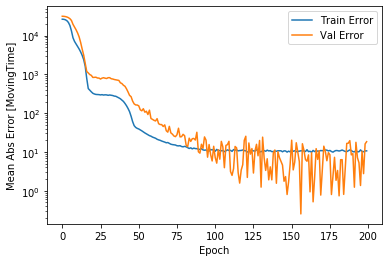

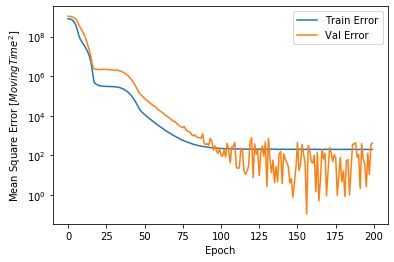

In [22]:
plot_history(pretrain_history)

Note: The final fluctuations could be suppressed by introducing a learning rate schedule, but for our purpose it is fine like that.

### Fine tune the model

Train the model for 1000 epochs with the training set, and record the training and validation accuracy in the `history` object.

In [23]:
EPOCHS = 1000

history = model.fit(normed_train_data.values, train_labels.values,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[PrintDot()])


.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
.........................
...........

Visualize the model's training progress using the stats stored in the `history` object.

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,1560496.375,1013.050171,1560496.375,965745.0625,970.331726,965745.0625,995
996,1559605.625,1013.501648,1559605.625,961761.3125,968.487732,961761.3125,996
997,1558718.250,1012.489136,1558718.250,966829.9375,970.743225,966829.9375,997
998,1557833.875,1012.941223,1557833.875,962837.5000,968.893738,962837.5000,998
999,1556951.375,1011.929077,1556951.375,967934.3125,971.152588,967934.3125,999


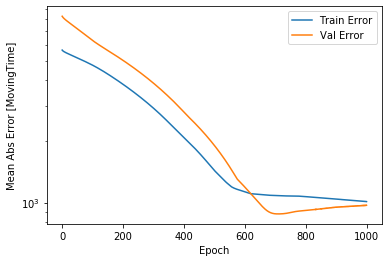

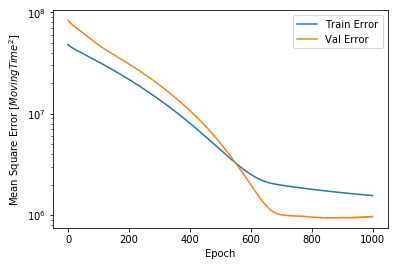

In [25]:
plot_history(history)

As our data set of real GPX tracks is very small, the optimal choice of the epoch for ending training depends on the distribution of tracks between training, validation and testing data. The above choice led to quite stable results.


### Make predictions

Finally, predict walking time values using data in the testing set:

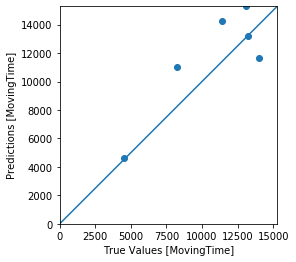

In [26]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels.values, test_predictions)
max_val = max(max(test_labels.values), max(test_predictions))
plt.xlabel('True Values [MovingTime]')
plt.ylabel('Predictions [MovingTime]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, max_val])
plt.ylim([0, max_val])
_ = plt.plot([0, max_val], [0, max_val])

It looks like our model predicts reasonably well, as the results should be as close to the diagonal as possible. Let's take a look at the error distribution.

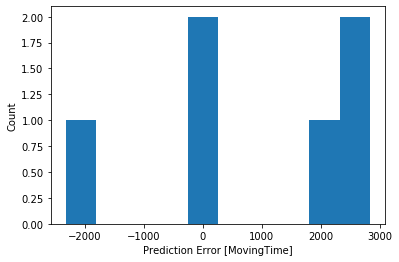

In [27]:
error = test_predictions - test_labels
plt.hist(error, bins = 10) # 25
plt.xlabel("Prediction Error [MovingTime]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

If our model yielded a reasonable training, validation and testing performance, we can export it here for future use:

In [28]:
model.save('model_hikingTimePrediction.h5')

## Conclusion

This notebook presents the training of an algorithm for prediting walking times for hiking (but it can also be applied to many other outdoor activities). We accomplished this by treating it as a regression problem.

We found that pretraining based on a model for estimating hiking times is not really necessary, but can give some guidance for formulating the model architecture. Without such an analytical model, we could find the best architecture as the soluation of an optimization problem.